# InfoFlow

This notebook performs InfoFlow community detection, and performs graph analysis on the resultant communities

## Below are configuration parameters

In [1]:
infoflow_dir = r'/home/felix/Work/Community Detection/InfoFlow'
jar_name = "infoflow"
scala_version = "2.11"
infoflow_version = "0.2.5"

In [2]:
graph = "Nets/data/science2004/science2004.net"

master = "local[*]"
num_executors = "1"
executor_cores = "8"
driver_memory = "60G"
executor_memory = "60G"

algorithm = "InfoFlow"
pagerank_tele = 0.15
pagerank_error_threshold_factor = 20

log_path = "Output/log.txt"
parquet_path = ""
rdd_path = ""
txt_path = "Output/vertex.txt"
full_json_path = ""
reduced_json_path = "Output/graph.json"
debug = "false"

## Set up environment and run InfoFlow

In [3]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph
from ipywidgets import widgets, interact

In [4]:
if not os.path.exists(infoflow_dir):
    raise RuntimeError("Working directory {} does not exist".format(infoflow_dir))

os.chdir(infoflow_dir)

if os.getcwd() != infoflow_dir:
    raise RuntimeError("Working directory {} does not exist".format(infoflow_dir))

In [5]:
def runInfoFlow():
    """Set up config file and runs InfoFlow"""

    infoflow_config = {
      "Graph": graph,
      "spark configs": {
        "Master": master,
        "num executors": num_executors,
        "executor cores": executor_cores,
        "driver memory": driver_memory,
        "executor memory": executor_memory
      },
      "Algorithm": {
        "Community detection algorithm": algorithm,
        "PageRank tele": pagerank_tele,
        "PageRank error threshold factor": pagerank_error_threshold_factor
      },
      "log": {
        "log path": log_path,
        "Parquet path": parquet_path,
        "RDD path": rdd_path,
        "txt path": txt_path,
        "Full Json path": full_json_path,
        "Reduced Json path": reduced_json_path,
        "debug": debug
      }
    }
    infoflow_config_string = json.dumps( infoflow_config, indent=2 )

    notebook_json = "notebook.json"
    with open(notebook_json,"w") as config_handle:
        config_handle.write(infoflow_config_string)

    jar = "{}_{}-{}.jar".format( jar_name, scala_version, infoflow_version )
    %time os.system("spark-submit target/scala-{}/{} {}".format( scala_version, jar, "notebook.json" ))

runInfoFlow()

CPU times: user 2.96 ms, sys: 3.99 ms, total: 6.96 ms
Wall time: 1min 57s


## Displays and analyses results

In [6]:
!cat {log_path}

Wed Jan 16 22:00:53 EST 2019: Running InfoFlow, version: 0.2.4
Wed Jan 16 22:00:53 EST 2019: Jar: infoflow_2.11-0.2.4.jar
Wed Jan 16 22:00:53 EST 2019: Spark version: 2.3.0
Wed Jan 16 22:00:53 EST 2019: Spark configurations:
Wed Jan 16 22:00:53 EST 2019: Executors: 1
Wed Jan 16 22:00:53 EST 2019: Executor cores: 8
Wed Jan 16 22:00:53 EST 2019: Driver memory: 60G
Wed Jan 16 22:00:53 EST 2019: Executor memory: 60G
Wed Jan 16 22:00:53 EST 2019: Reading Nets/data/science2004/science2004.net
Wed Jan 16 22:00:56 EST 2019: Finished reading from disk; parallelizing...
Wed Jan 16 22:01:05 EST 2019: Read in network with 7379 nodes and 893040 edges
Wed Jan 16 22:01:05 EST 2019: Initializing partitioning, calculating PageRank
Wed Jan 16 22:02:04 EST 2019: Finished initialization calculations
Wed Jan 16 22:02:04 EST 2019: Using InfoFlow algorithm:
Wed Jan 16 22:02:04 EST 2019: State 0: code length 13.163446995277198
Wed Jan 16 22:02:35 EST 2019: Merge 1: merging 7379 modules into 844 modules
Wed Ja

In [11]:
@interact( threshold_size="1e-3" )
def plotGraph( threshold_size ):
    """
    Plots the InfoFlow output graph, where each node is a module
    The node size indicates the ergodic frequency of the module

    :param str threshold_size: minimum ergodic frequency for the module to be shown

    """
    with open(reduced_json_path) as graphHandle:
        graphJS = json.load( graphHandle )
    graphData = nx.readwrite.json_graph.node_link_graph( graphJS, directed=True )

    custom_color_map = plt.get_cmap('Spectral')

    sub_nodes = []
    sub_nodes_size = []
    sub_nodes_color = []
    for i in range( len(graphJS['nodes']) ):
        if( float(graphJS['nodes'][i]['size']) >= float(threshold_size) ):
            sub_nodes.append( graphJS['nodes'][i]['name'] )
            sub_nodes_size.append(float( graphJS['nodes'][i]['size'] ) *30000)
            sub_nodes_color.append( len(sub_nodes_color) )

    map( lambda x: custom_color_map( float(x)/float(len(sub_nodes_color)) ), sub_nodes_color )
    
    filteredGraph = graphData.subgraph( sub_nodes )

    plt.figure( figsize=[20,10], clear=True )
    nx.draw_networkx_nodes( filteredGraph, pos=nx.circular_layout(filteredGraph), nodelist=filteredGraph.nodes, \
                           node_size=sub_nodes_size, \
                           alpha=0.5, node_color=sub_nodes_color )
    nx.draw_networkx_labels( filteredGraph, pos=nx.circular_layout(filteredGraph), nodelist=filteredGraph.nodes )
    nx.draw_networkx_edges( filteredGraph, pos=nx.circular_layout(filteredGraph), edgelist=filteredGraph.edges, alpha=0.2 )
    plt.xticks([])
    plt.yticks([])

interactive(children=(Text(value='1e-3', description='threshold_size'), Output()), _dom_classes=('widget-inter…

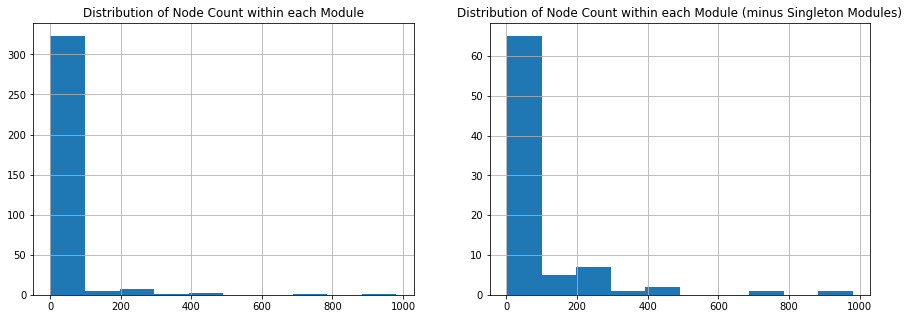

In [8]:
def plotModuleNodeCountHist():
    """Plots the histogram of the node count within each module"""
    # commented out implementation based off reading txt_path
    #vertices = pd.read_csv( txt_path, delimiter = '|' )
    #vertices.columns = vertices.columns.str.strip()

    #vertices.drop('Name',axis=1) \
    #.groupby('Module', as_index=False).count() \
    #['Index'].hist()
    #plt.title("Distribution of Node Count within each Module")

    with open(reduced_json_path) as graphHandle:
        graphJS = json.load( graphHandle )
    node_sizes = pd.io.json.json_normalize( graphJS['nodes'] )['count']
    node_sizes = pd.to_numeric( node_sizes )

    fig, (ax1,ax2) = plt.subplots( ncols=2, figsize=(15,5) )

    node_sizes.hist(ax=ax1)
    ax1.set_title("Distribution of Node Count within each Module")

    filtered_node_sizes = node_sizes[ node_sizes > 1 ]
    filtered_node_sizes.hist(ax=ax2)
    ax2.set_title("Distribution of Node Count within each Module (minus Singleton Modules)")

plotModuleNodeCountHist()

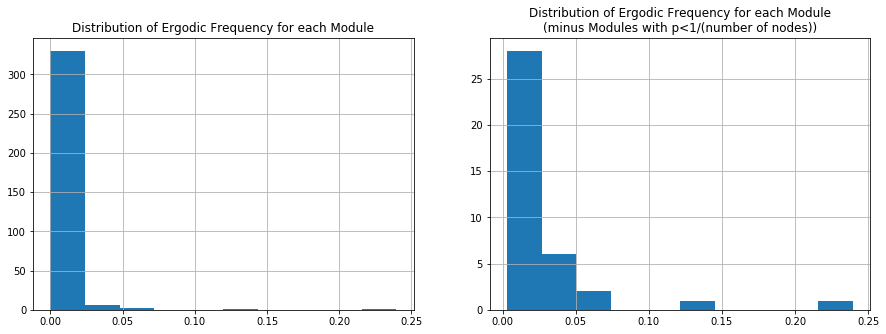

In [9]:
def plotModuleNodeProbHist():
    """Plots the histogram of the module size, according to ergodic frequency"""
    with open(reduced_json_path) as graphHandle:
        graphJS = json.load( graphHandle )
    node_sizes = pd.io.json.json_normalize( graphJS['nodes'] )['size']
    node_sizes = pd.to_numeric( node_sizes )

    fig, (ax1,ax2) = plt.subplots( ncols=2, figsize=(15,5) )

    node_sizes.hist(ax=ax1)
    ax1.set_title("Distribution of Ergodic Frequency for each Module")

    number_of_nodes = node_sizes.count()
    filtered_node_sizes = node_sizes[ node_sizes >= 1.0/float(number_of_nodes) ]
    filtered_node_sizes.hist(ax=ax2)
    ax2.set_title("Distribution of Ergodic Frequency for each Module\n(minus Modules with p<1/(number of nodes))")

plotModuleNodeProbHist()

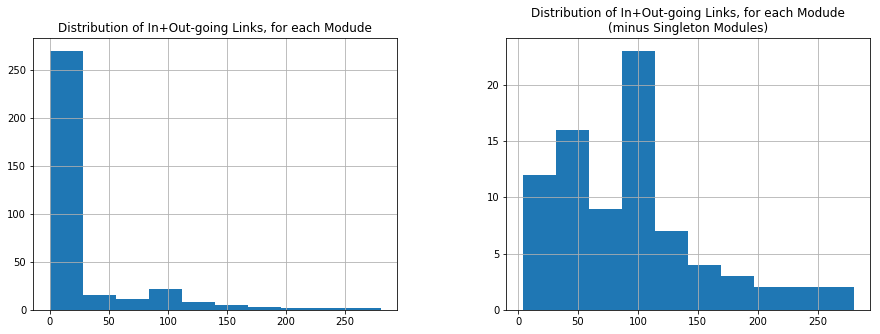

In [10]:
def plotConnections():
    """Plot the histogram of the number of connections per module"""
    with open(reduced_json_path) as graphHandle:
        graphJS = json.load( graphHandle )
    nodes = pd.io.json.json_normalize( graphJS['nodes'] )
    links = pd.io.json.json_normalize( graphJS['links'] )

    source_count = links.groupby('source', as_index=False).count()
    target_count = links.groupby('target', as_index=False).count()

    columns = source_count .merge ( target_count, how='outer', left_on='source', right_on='target' ) \
    .apply( lambda row: pd.Series([ row.source_x, row.value_x+row.value_y ]), axis=1 )
    columns.columns = ['node','count']
    columns = columns.drop( [0], axis=0 )

    node_link_count = nodes .merge( columns, how='left', left_on='id', right_on='node' )[['id','count_y']] \
    .apply( lambda row: pd.Series([ row.id, row.count_y if not np.isnan(row.count_y) else 0 ]), axis=1 )
    node_link_count.columns = ['node','count']
    node_link_count.sort_values( by='node', ascending=False, inplace=True )

    fig, (ax1,ax2) = plt.subplots( ncols=2, figsize=(15,5) )

    node_link_count.hist(ax=ax1)
    ax1.set_title("Distribution of In+Out-going Links, for each Modude")

    filtered_node_link_count = node_link_count['count'][ node_link_count['count'] > 0 ]
    filtered_node_link_count.hist(ax=ax2)
    ax2.set_title("Distribution of In+Out-going Links, for each Modude\n(minus Singleton Modules)")

plotConnections()